In [1]:
%reset -sf

import tensorflow as tf
import tf_keras
print("Tensorflow:", tf.__version__)

# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        
        # Instead of enabling memory growth, set a memory limit
        # memory_limit = 16_376 / 2 # Set the memory limit in MB
        memory_limit = -1
        if memory_limit >= 0:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
            )
            
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2025-04-06 06:39:21.709176: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-06 06:39:21.732117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow: 2.16.1
1 Physical GPUs, 1 Logical GPU


2025-04-06 06:39:22.825698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13218 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [2]:
import sys
import os
import glob

HOME_PATH = os.path.abspath("/root/work/QE-mls") # path to QE_mls
sys.path.append(HOME_PATH + "/qe")

import paper_plot as pp

plot = pp.Plotter()

import pandas as pd
import numpy as np
import scipy as sp
import ROOT
from ROOT import TLorentzVector, TVector3
import multiprocessing
WORKERS = 16

from matplotlib import pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


SEED = 42  # set random seed (global variable)
GEV = 1e-3

In [3]:
import full_data as data

# reco
lead_lep = data.Lead_lep()
sublead_lep = data.Sublead_lep()
met = data.Met()

# truth
truth_lead_lep = data.Truth_lead_lep()
truth_sublead_lep = data.Truth_sublead_lep()
Truth_dilep = data.Truth_dilep()
truth_met = data.Truth_met()

# target Ws
w_lead = data.Lead_w()
w_sublead = data.Sublead_w()
mc_weight = data.MC_weight()

['/CGLMP', '/RecoLep0', '/RecoLep1', '/RecoMET', '/TruthCandLep0', '/TruthCandLep1', '/TruthCandMET', '/TruthHiggs', '/TruthLep0', '/TruthLep1', '/TruthLepN', '/TruthLepP', '/TruthNu0', '/TruthNu1', '/TruthNuN', '/TruthNuP', '/TruthW0', '/TruthW1', '/TruthWN', '/TruthWP', '/eventWeight', '/mcWeight', '/recoWeight', '/weight']


In [4]:
# define preselection cuts

cut_pre_pt_lead = lead_lep.pt > 22
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > 15
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > 10
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > 20
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)


0
29961
44269
89634
157782


In [5]:
# truth
truth_lead_lep_px = pd.DataFrame(truth_lead_lep.px[PRE_CUT])
truth_lead_lep_py = pd.DataFrame(truth_lead_lep.py[PRE_CUT])
truth_lead_lep_pz = pd.DataFrame(truth_lead_lep.pz[PRE_CUT])
truth_lead_lep_energy = pd.DataFrame(truth_lead_lep.energy[PRE_CUT])
truth_lead_lep_p4 = pd.concat(
	[truth_lead_lep_px, truth_lead_lep_py, truth_lead_lep_pz, truth_lead_lep_energy],
	axis=1,
).to_numpy()
truth_lead_lep_pt = pd.DataFrame(truth_lead_lep.pt[PRE_CUT])
truth_lead_lep_eta = pd.DataFrame(truth_lead_lep.eta[PRE_CUT])
truth_lead_lep_phi = pd.DataFrame(truth_lead_lep.phi[PRE_CUT])

truth_sublead_lep_px = pd.DataFrame(truth_sublead_lep.px[PRE_CUT])
truth_sublead_lep_py = pd.DataFrame(truth_sublead_lep.py[PRE_CUT])
truth_sublead_lep_pz = pd.DataFrame(truth_sublead_lep.pz[PRE_CUT])
truth_sublead_lep_energy = pd.DataFrame(truth_sublead_lep.energy[PRE_CUT])
truth_sublead_lep_p4 = pd.concat(
	[truth_sublead_lep_px, truth_sublead_lep_py, truth_sublead_lep_pz, truth_sublead_lep_energy],
	axis=1,
).to_numpy()
truth_sublead_lep_pt = pd.DataFrame(truth_sublead_lep.pt[PRE_CUT])
truth_sublead_lep_eta = pd.DataFrame(truth_sublead_lep.eta[PRE_CUT])
truth_sublead_lep_phi = pd.DataFrame(truth_sublead_lep.phi[PRE_CUT])

# reco
lead_lep_px = pd.DataFrame(lead_lep.px[PRE_CUT])
lead_lep_py = pd.DataFrame(lead_lep.py[PRE_CUT])
lead_lep_pz = pd.DataFrame(lead_lep.pz[PRE_CUT])
lead_lep_energy = pd.DataFrame(lead_lep.energy[PRE_CUT])
lead_lep_p4 = pd.concat(
	[lead_lep_px, lead_lep_py, lead_lep_pz, lead_lep_energy],
	axis=1,
).to_numpy()
lead_lep_pt = pd.DataFrame(lead_lep.pt[PRE_CUT])
lead_lep_eta = pd.DataFrame(lead_lep.eta[PRE_CUT])
lead_lep_phi = pd.DataFrame(lead_lep.phi[PRE_CUT])
lead_lep_charge = pd.DataFrame(lead_lep.q[PRE_CUT])

sublead_lep_px = pd.DataFrame(sublead_lep.px[PRE_CUT])
sublead_lep_py = pd.DataFrame(sublead_lep.py[PRE_CUT])
sublead_lep_pz = pd.DataFrame(sublead_lep.pz[PRE_CUT])
sublead_lep_energy = pd.DataFrame(sublead_lep.energy[PRE_CUT])
sublead_lep_p4 = pd.concat(
	[sublead_lep_px, sublead_lep_py, sublead_lep_pz, sublead_lep_energy],
	axis=1,
).to_numpy()
sublead_lep_pt = pd.DataFrame(sublead_lep.pt[PRE_CUT])
sublead_lep_eta = pd.DataFrame(sublead_lep.eta[PRE_CUT])
sublead_lep_phi = pd.DataFrame(sublead_lep.phi[PRE_CUT])
sublead_lep_charge = pd.DataFrame(sublead_lep.q[PRE_CUT])

met_px = pd.DataFrame(met.px[PRE_CUT])
met_py = pd.DataFrame(met.py[PRE_CUT])
met_pt = pd.DataFrame(met.pt[PRE_CUT])
met_phi = pd.DataFrame(met.phi[PRE_CUT])

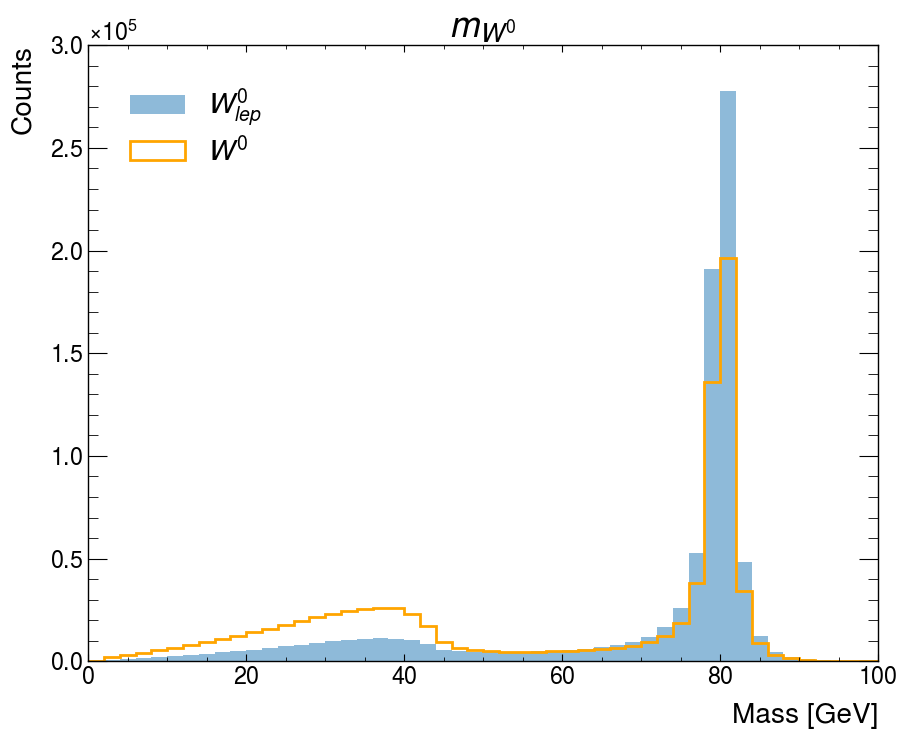

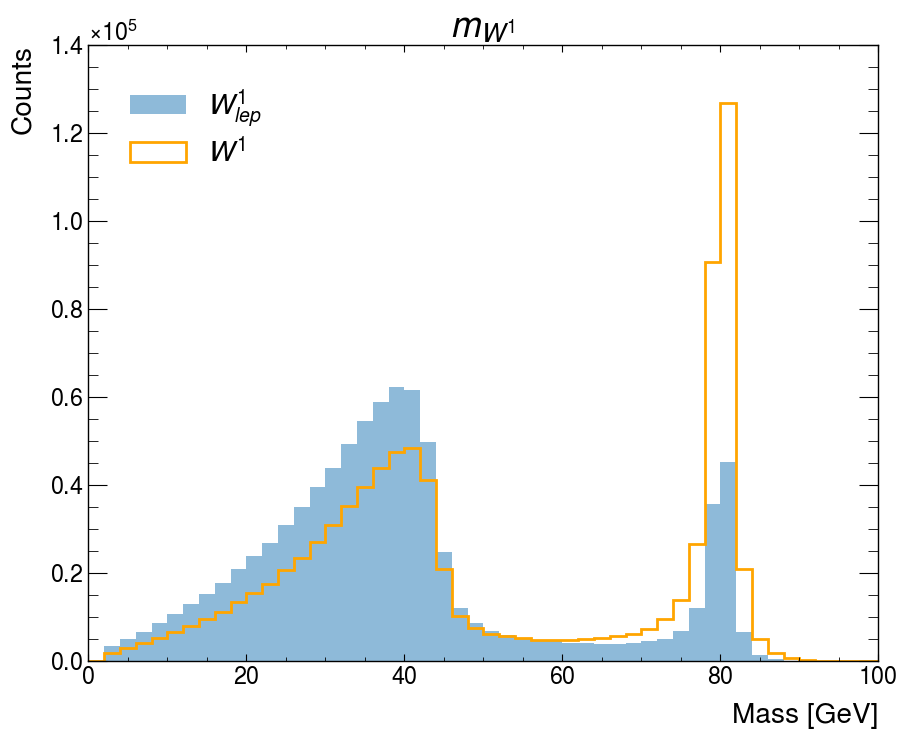

In [6]:
## Interesting variables
# lead_lep w
w_lead_px = pd.DataFrame(w_lead.px[PRE_CUT])
w_lead_py = pd.DataFrame(w_lead.py[PRE_CUT])
w_lead_pz = pd.DataFrame(w_lead.pz[PRE_CUT])
w_lead_e = pd.DataFrame(w_lead.energy[PRE_CUT])
w_lead_pt = pd.DataFrame(w_lead.pt[PRE_CUT])
w_lead_eta = pd.DataFrame(w_lead.eta[PRE_CUT])
w_lead_phi = pd.DataFrame(w_lead.phi[PRE_CUT])
w_lead_m = pd.DataFrame(w_lead.m[PRE_CUT])

w_sublead_px = pd.DataFrame(w_sublead.px[PRE_CUT])
w_sublead_py = pd.DataFrame(w_sublead.py[PRE_CUT])
w_sublead_pz = pd.DataFrame(w_sublead.pz[PRE_CUT])
w_sublead_e = pd.DataFrame(w_sublead.energy[PRE_CUT])
w_sublead_pt = pd.DataFrame(w_sublead.pt[PRE_CUT])
w_sublead_eta = pd.DataFrame(w_sublead.eta[PRE_CUT])
w_sublead_phi = pd.DataFrame(w_sublead.phi[PRE_CUT])
w_sublead_m = pd.DataFrame(w_sublead.m[PRE_CUT])

# pure lead w (consider pt)
leadlep_lead = w_lead.pt > w_sublead.pt
lead_w_px = pd.concat([pd.DataFrame(w_lead.px)[leadlep_lead], pd.DataFrame(w_sublead.px)[~leadlep_lead]], ignore_index=False).sort_index()[PRE_CUT]
lead_w_py = pd.concat([pd.DataFrame(w_lead.py)[leadlep_lead], pd.DataFrame(w_sublead.py)[~leadlep_lead]], ignore_index=False).sort_index()[PRE_CUT]
lead_w_pz = pd.concat([pd.DataFrame(w_lead.pz)[leadlep_lead], pd.DataFrame(w_sublead.pz)[~leadlep_lead]], ignore_index=False).sort_index()[PRE_CUT]
lead_w_e = pd.concat([pd.DataFrame(w_lead.energy)[leadlep_lead], pd.DataFrame(w_sublead.energy)[~leadlep_lead]], ignore_index=False).sort_index()[PRE_CUT]
sublead_w_px = pd.concat([pd.DataFrame(w_lead.px)[~leadlep_lead], pd.DataFrame(w_sublead.px)[leadlep_lead]], ignore_index=False).sort_index()[PRE_CUT]  
sublead_w_py = pd.concat([pd.DataFrame(w_lead.py)[~leadlep_lead], pd.DataFrame(w_sublead.py)[leadlep_lead]], ignore_index=False).sort_index()[PRE_CUT]
sublead_w_pz = pd.concat([pd.DataFrame(w_lead.pz)[~leadlep_lead], pd.DataFrame(w_sublead.pz)[leadlep_lead]], ignore_index=False).sort_index()[PRE_CUT]
sublead_w_e = pd.concat([pd.DataFrame(w_lead.energy)[~leadlep_lead], pd.DataFrame(w_sublead.energy)[leadlep_lead]], ignore_index=False).sort_index()[PRE_CUT]
lead_w_m = pd.concat([pd.DataFrame(w_lead.m)[leadlep_lead], pd.DataFrame(w_sublead.m)[~leadlep_lead]], ignore_index=False).sort_index()[PRE_CUT]
sublead_w_m = pd.concat([pd.DataFrame(w_lead.m)[~leadlep_lead], pd.DataFrame(w_sublead.m)[leadlep_lead]], ignore_index=False).sort_index()[PRE_CUT]  

# check them wiht histograms
bin_edges = np.linspace(0, 100, 51)
figure = plt.figure(figsize=(10, 8))
plt.hist(
    w_lead_m.values.ravel(),
    bins=bin_edges,
    color="tab:blue",
    alpha=0.5,
    label=r"$W^{0}_{lep}$",
    histtype="stepfilled",
    stacked=False,
    density=False
)
plt.hist(
    lead_w_m.values.ravel(),
    bins=bin_edges,
    color="orange",
    label=r"$W^{0}$",
    histtype="step",
    linewidth=2,
    stacked=False,
    density=False
)
plt.xlabel(r"Mass [GeV]", labelpad=10)
plt.ylabel("Counts")
plt.title(r"$m_{W^{0}}$", fontsize=26)
plt.legend(loc="best", prop={'size': 20})
plt.show()

bin_edges = np.linspace(0, 100, 51)
figure = plt.figure(figsize=(10, 8))
plt.hist(
    w_sublead_m.values.ravel(),
    bins=bin_edges,
    color="tab:blue",
    alpha=0.5,
    label=r"$W^{1}_{lep}$",
    histtype="stepfilled",
    stacked=False,
    density=False
)
plt.hist(
    sublead_w_m.values.ravel(),
    bins=bin_edges,
    color="orange",
    label=r"$W^{1}$",
    histtype="step",
    linewidth=2,
    stacked=False,
    density=False
)
plt.xlabel(r"Mass [GeV]", labelpad=10)
plt.ylabel("Counts")
plt.title(r"$m_{W^{1}}$", fontsize=26)
plt.legend(loc="best", prop={'size': 20})
plt.show()

In [7]:

## Observing variables

obs_kin = np.column_stack(
    (
        lead_lep_px,
        lead_lep_py,
        lead_lep_pz,
        lead_lep_energy,
        lead_lep_pt,
        lead_lep_eta,
        lead_lep_phi,
        lead_lep_charge,
        sublead_lep_px,
        sublead_lep_py,
        sublead_lep_pz,
        sublead_lep_energy,
        sublead_lep_pt,
        sublead_lep_eta,
        sublead_lep_phi,
        sublead_lep_charge,
        met_px,
        met_py,
        met_pt,
        met_phi,
    )
)

# Kinematics of observing variables (inputs for training)
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array

ROBUST_OBS = RobustScaler()
obs_kin = ROBUST_OBS.fit_transform(obs_kin)
# print(type(obs_kin))

int_kin shape: (851115, 20)


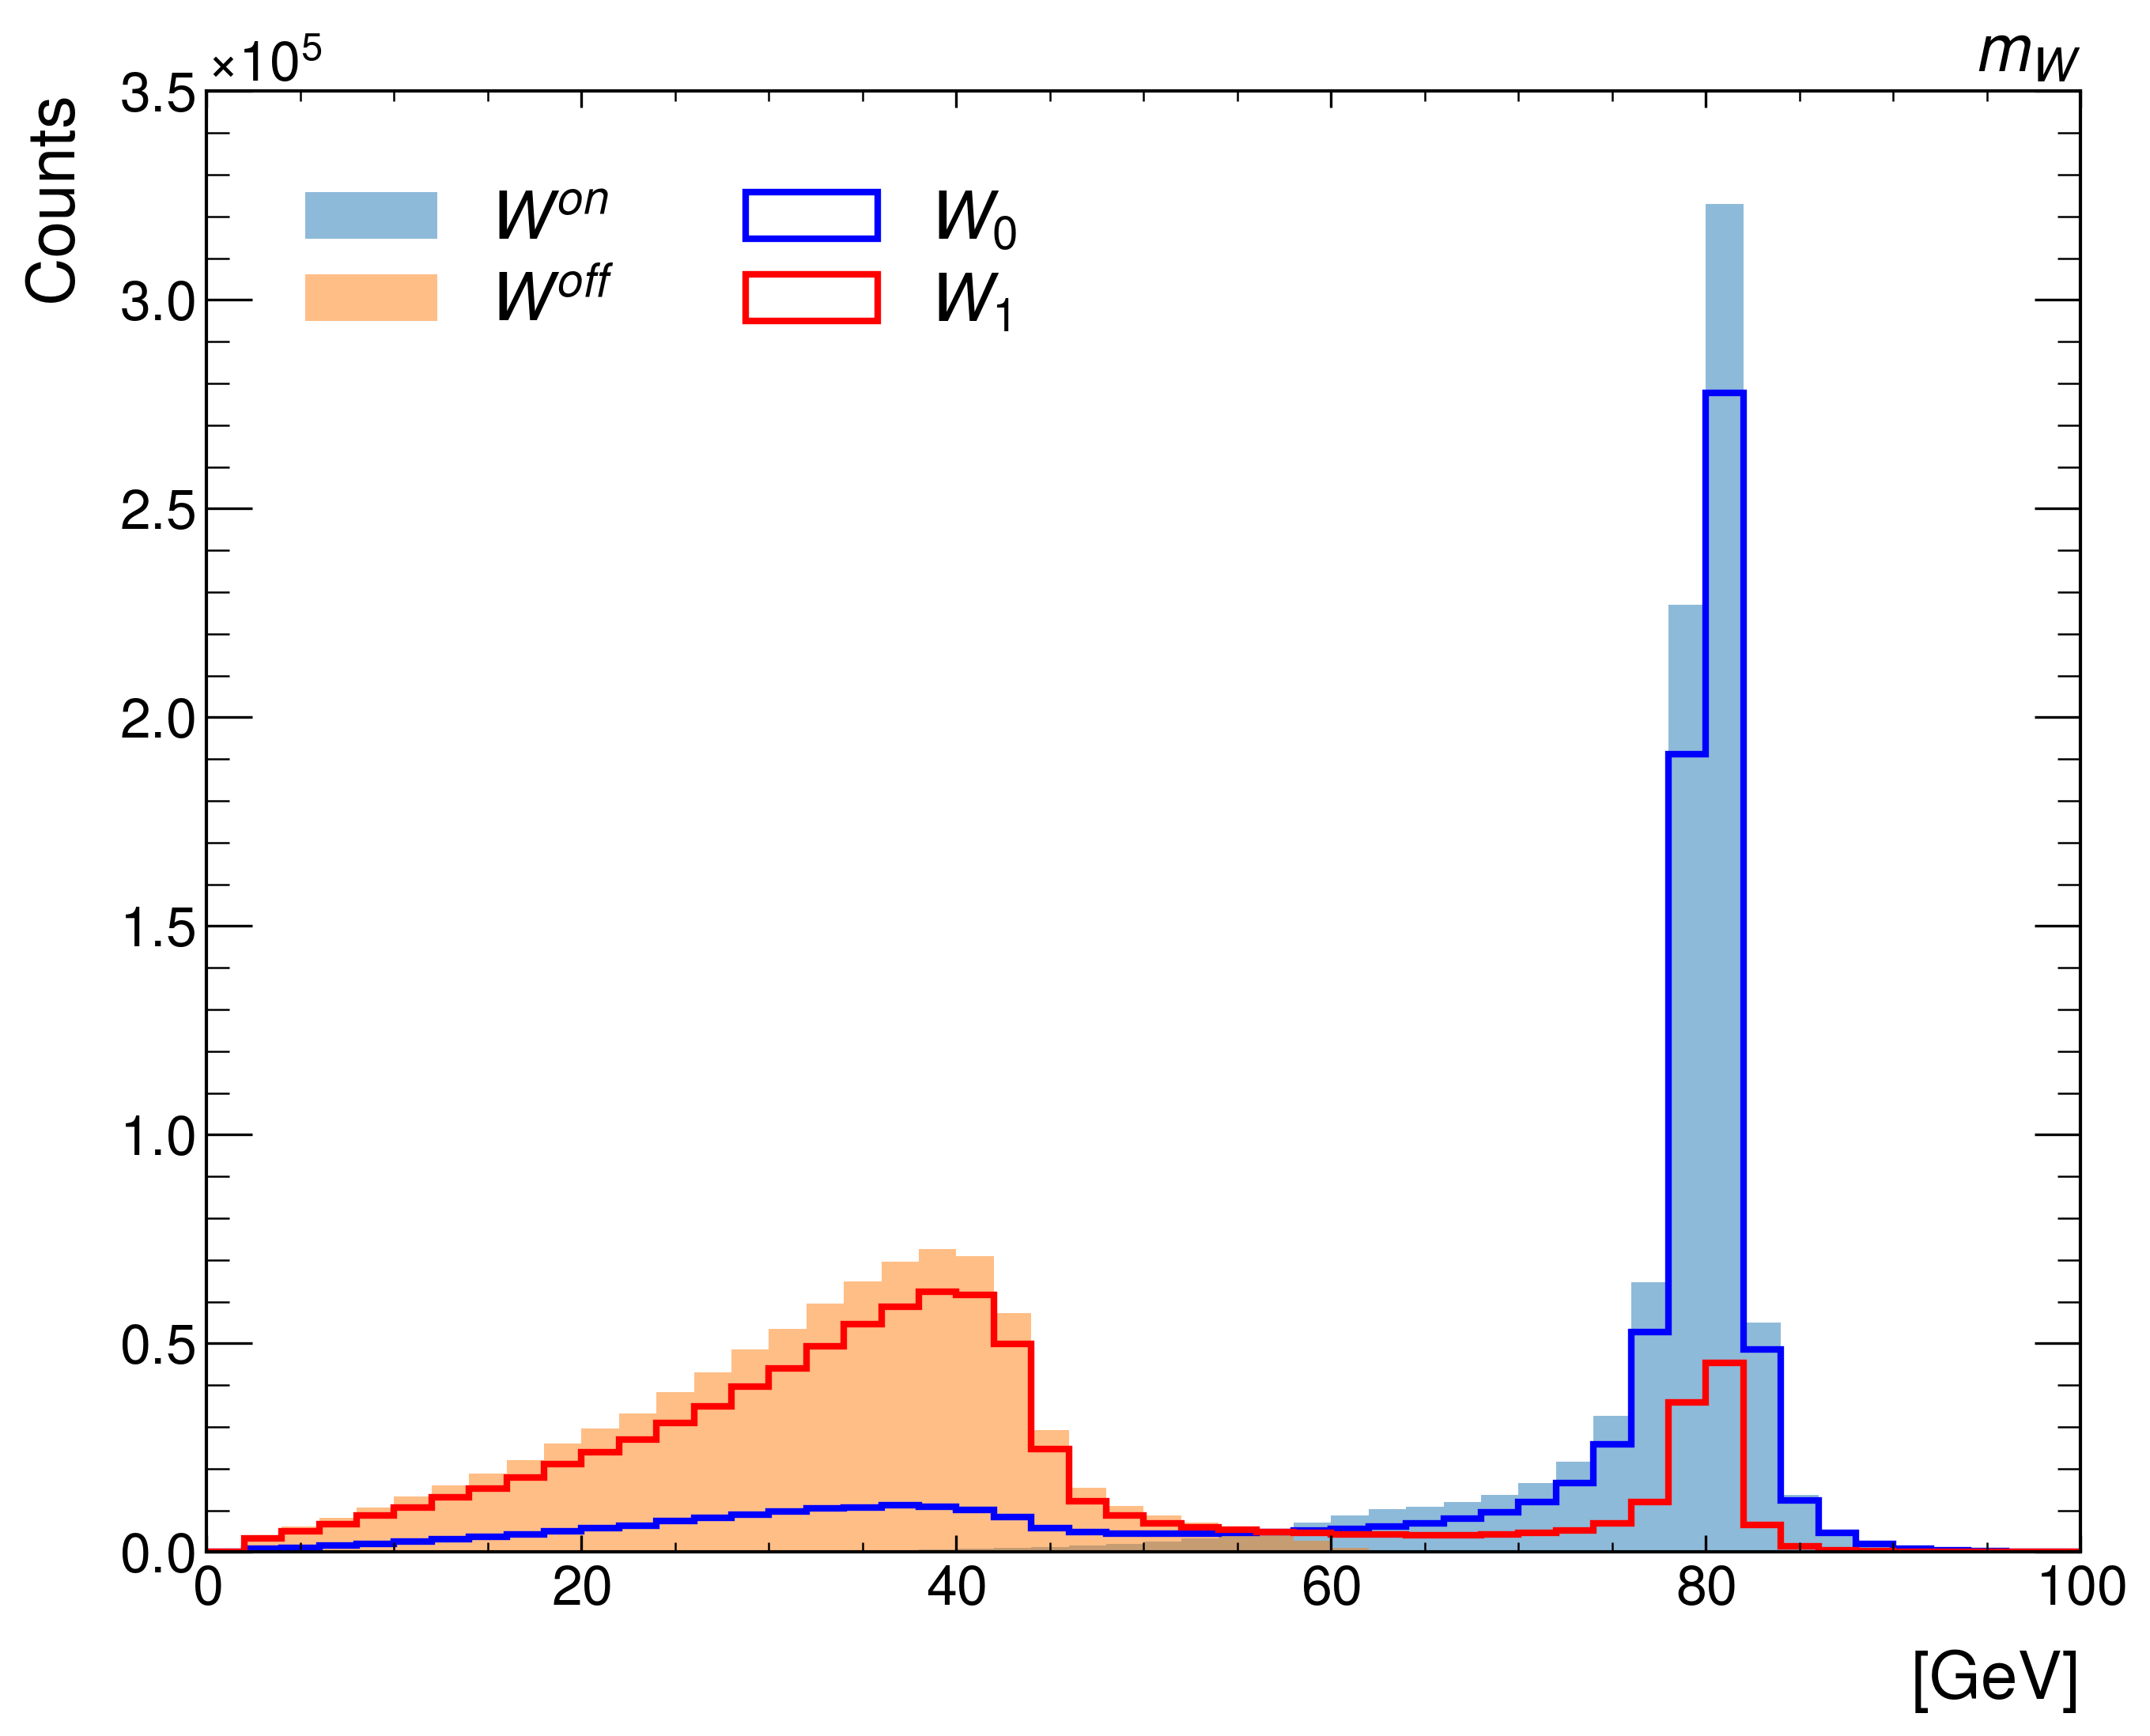

In [8]:
# target variables on-(off-)shell Ws

lead_onshell_mask = w_lead_m > w_sublead_m
onshell_w_m = pd.concat(
		[
			w_lead_m[lead_onshell_mask].dropna(), 
			w_sublead_m[~lead_onshell_mask].dropna(),
		], ignore_index=False
    ).sort_index()
offshell_w_m = pd.concat(
		[
			w_lead_m[~lead_onshell_mask].dropna(), 
			w_sublead_m[lead_onshell_mask].dropna(),
		], ignore_index=False
	).sort_index()

# check them with histograms
bin_edges = np.linspace(0, 100, 51)
figure = plt.figure(figsize=(10, 8), dpi=300)
plt.hist(
	onshell_w_m.values.ravel(),
	bins=bin_edges,
	color="tab:blue",
	alpha=0.5,
	label=r"$W^{on}$",
	histtype="stepfilled",
	stacked=False,
	density=False,
)
plt.hist(
	offshell_w_m.values.ravel(),
	bins=bin_edges,
	color="tab:orange",
	alpha=0.5,
	label=r"$W^{off}$",
	histtype="stepfilled",
	stacked=False,
	density=False,
)
plt.hist(
	w_lead_m,
	bins=bin_edges,
	color="blue",
	alpha=1.0,
	linewidth=2,
	label=r"$W_0$",
	histtype="step",
	stacked=False,
	density=False,
)
plt.hist(
	w_sublead_m,
	bins=bin_edges,
	color="red",
	alpha=1.0,
	linewidth=2,
	label=r"$W_1$",
	histtype="step",
	stacked=False,
	density=False,
)
plt.xlabel(r"[GeV]", labelpad=10)
plt.ylabel("Counts")
plt.title(r"$m_{W}$", fontsize=20, loc="right")
plt.legend(loc="best", prop={'size': 20}, ncol=2)
plt.show()
plt.close()

In [9]:
# Kinematics of interesting variables (target for training)
int_kin = np.concatenate(
    [
        lead_onshell_mask.astype(int),
    ],
    axis=-1,
)
print("int_kin shape:", int_kin.shape)
# int_kin = int_kin.to_numpy()  # convert to numpy array
print(type(int_kin))

int_kin shape: (851115, 1)
<class 'numpy.ndarray'>


In [10]:
print("Leading W is on-shell:", int_kin.sum() / len(int_kin))  # check the ratio of on-shell W

Leading W is on-shell: 0.8203110038008965


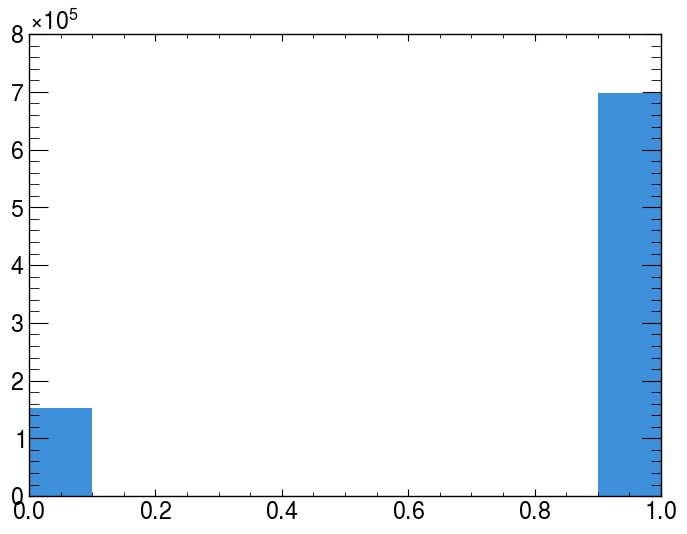

In [11]:
plt.hist(int_kin)
plt.show()

In [12]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.8,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
# test_x = np.concatenate([test_x, valid_x], axis=0)

train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]
# test_y = np.concatenate([test_y, valid_y], axis=0)

print("Total evts:", len(indices_arr))
print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

Total evts: 851115
X (Interest)
Training data shape: (680892, 20);
Validing data shape: (85111, 20);
Testing data shape: (85112, 20).
Y (Observed)
Training data shape: (680892, 1);
Validing data shape: (85111, 1);
Testing data shape: (85112, 1).


In [13]:
# training variables
BATCH_SIZE = 512
EPOCHS = 1024
LEARNING_RATE = 1e-5

# create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(train_x, tf.float32), 
    tf.cast(train_y, tf.float32)
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(valid_x, tf.float32), 
    tf.cast(valid_y, tf.float32)
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
def dense_dropout_block(x, units, activation="swish", dropout_rate=0.0, l2=1e-6):
    x = tf.keras.layers.Dense(
        units=units,
        use_bias=False,
        kernel_regularizer=tf.keras.regularizers.L2(l2),
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    return x

def residual_block(x, units, activation="swish", dropout_rate=0.0, l2=0.0):
    y = dense_dropout_block(x, units, activation=activation, dropout_rate=dropout_rate, l2=l2)
    y = dense_dropout_block(y, units, activation=activation, dropout_rate=dropout_rate, l2=l2)
    if x.shape[-1] != units:
        x = tf.keras.layers.Dense(units, activation=None, use_bias=False)(x)
    z = tf.keras.layers.Add()([x, y]) 
    z = tf.keras.layers.BatchNormalization()(z) 
    z = tf.keras.layers.Activation(activation)(z)
    return z

def build_model(input_shape):
    inputs = tf.keras.layers.Input(shape=(input_shape,), dtype=tf.float32)
    x = inputs

    # Stack residual blocks
    for _ in range(2):
        x = residual_block(x, 256, dropout_rate=0.2)
        x = residual_block(x, 128, dropout_rate=0.2)
    for _ in range(2):
        x = residual_block(x, 128, dropout_rate=0.2)
        x = residual_block(x, 64, dropout_rate=0.2)

    # Bottleneck
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(8, activation="swish")(x)

    outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [15]:
model = build_model(train_x.shape[-1])
model.summary()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.losses.binary_crossentropy,
    metrics=["accuracy"],
)

# Early stopping and learning rate scheduler
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    # min_delta=1e-3,
    patience=10,
    mode="auto",
    restore_best_weights=False,
)


def scheduler(epoch, lr):
    if epoch < 512:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1 * LEARNING_RATE))


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Fit the model using generators
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=[stop_early, lr_scheduler],
    verbose=2,
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │      5,120 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,536 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │      5,120 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense_2[0][0],    │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,768 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,384 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 491,537 (1.88 MB)

 Trainable params: 484,625 (1.85 MB)

 Non-trainable params: 6,912 (27.00 KB)

Epoch 1/1024
1330/1330 - 37s - 28ms/step - accuracy: 0.6513 - loss: 0.7154 - val_accuracy: 0.8173 - val_loss: 0.6583 - learning_rate: 1.0000e-05
Epoch 2/1024
1330/1330 - 4s - 3ms/step - accuracy: 0.7986 - loss: 0.6459 - val_accuracy: 0.8186 - val_loss: 0.6086 - learning_rate: 1.0000e-05
Epoch 3/1024
1330/1330 - 5s - 3ms/step - accuracy: 0.8034 - loss: 0.6006 - val_accuracy: 0.8189 - val_loss: 0.5676 - learning_rate: 1.0000e-05
Epoch 4/1024
1330/1330 - 4s - 3ms/step - accuracy: 0.8059 - loss: 0.5617 - val_accuracy: 0.8198 - val_loss: 0.5295 - learning_rate: 1.0000e-05
Epoch 5/1024
1330/1330 - 4s - 3ms/step - accuracy: 0.8088 - loss: 0.5271 - val_accuracy: 0.8207 - val_loss: 0.4972 - learning_rate: 1.0000e-05
Epoch 6/1024
1330/1330 - 4s - 3ms/step - accuracy: 0.8128 - loss: 0.4992 - val_accuracy: 0.8211 - val_loss: 0.4733 - learning_rate: 1.0000e-05
Epoch 7/1024
1330/1330 - 4s - 3ms/step - accuracy: 0.8163 - loss: 0.4728 - val_accuracy: 0.8212 - val_loss: 0.4401 - learning_rate: 1.0000e-

I0000 00:00:1743921574.702640  955297 service.cc:145] XLA service 0x709040040640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743921574.702656  955297 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-04-06 06:39:34.830301: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-06 06:39:35.361408: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1743921580.312287  955661 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1743921580.469575  955661 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_7', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:17

In [16]:
# Make a directory
dir_name = HOME_PATH + "/10th_trial/ww_classification_result/"
savedmodel_path = dir_name + "saved_model"
name = "ww_classifier"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
        print(f"Directory {dir_name} cleaned.")
    print(f"Directory {dir_name} exists.")
else:
    os.makedirs(dir_name)
    print(f"Directory {dir_name} created.")

# save modela
model.save(dir_name + name + ".keras", save_format="keras", overwrite=True)
tf.saved_model.save(model, savedmodel_path) # save model in saved_model format --> use in the onnx 

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

Directory /root/work/QE-mls/10th_trial/ww_classification_result/ cleaned.
Directory /root/work/QE-mls/10th_trial/ww_classification_result/ exists.
INFO:tensorflow:Assets written to: /root/work/QE-mls/10th_trial/ww_classification_result/saved_model/assets


INFO:tensorflow:Assets written to: /root/work/QE-mls/10th_trial/ww_classification_result/saved_model/assets


2660/2660 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


I0000 00:00:1743922798.628280 1006872 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1743922802.197274 1007024 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2', 8 bytes spill stores, 8 bytes spill loads



Accuracy: 0.8529232070683335


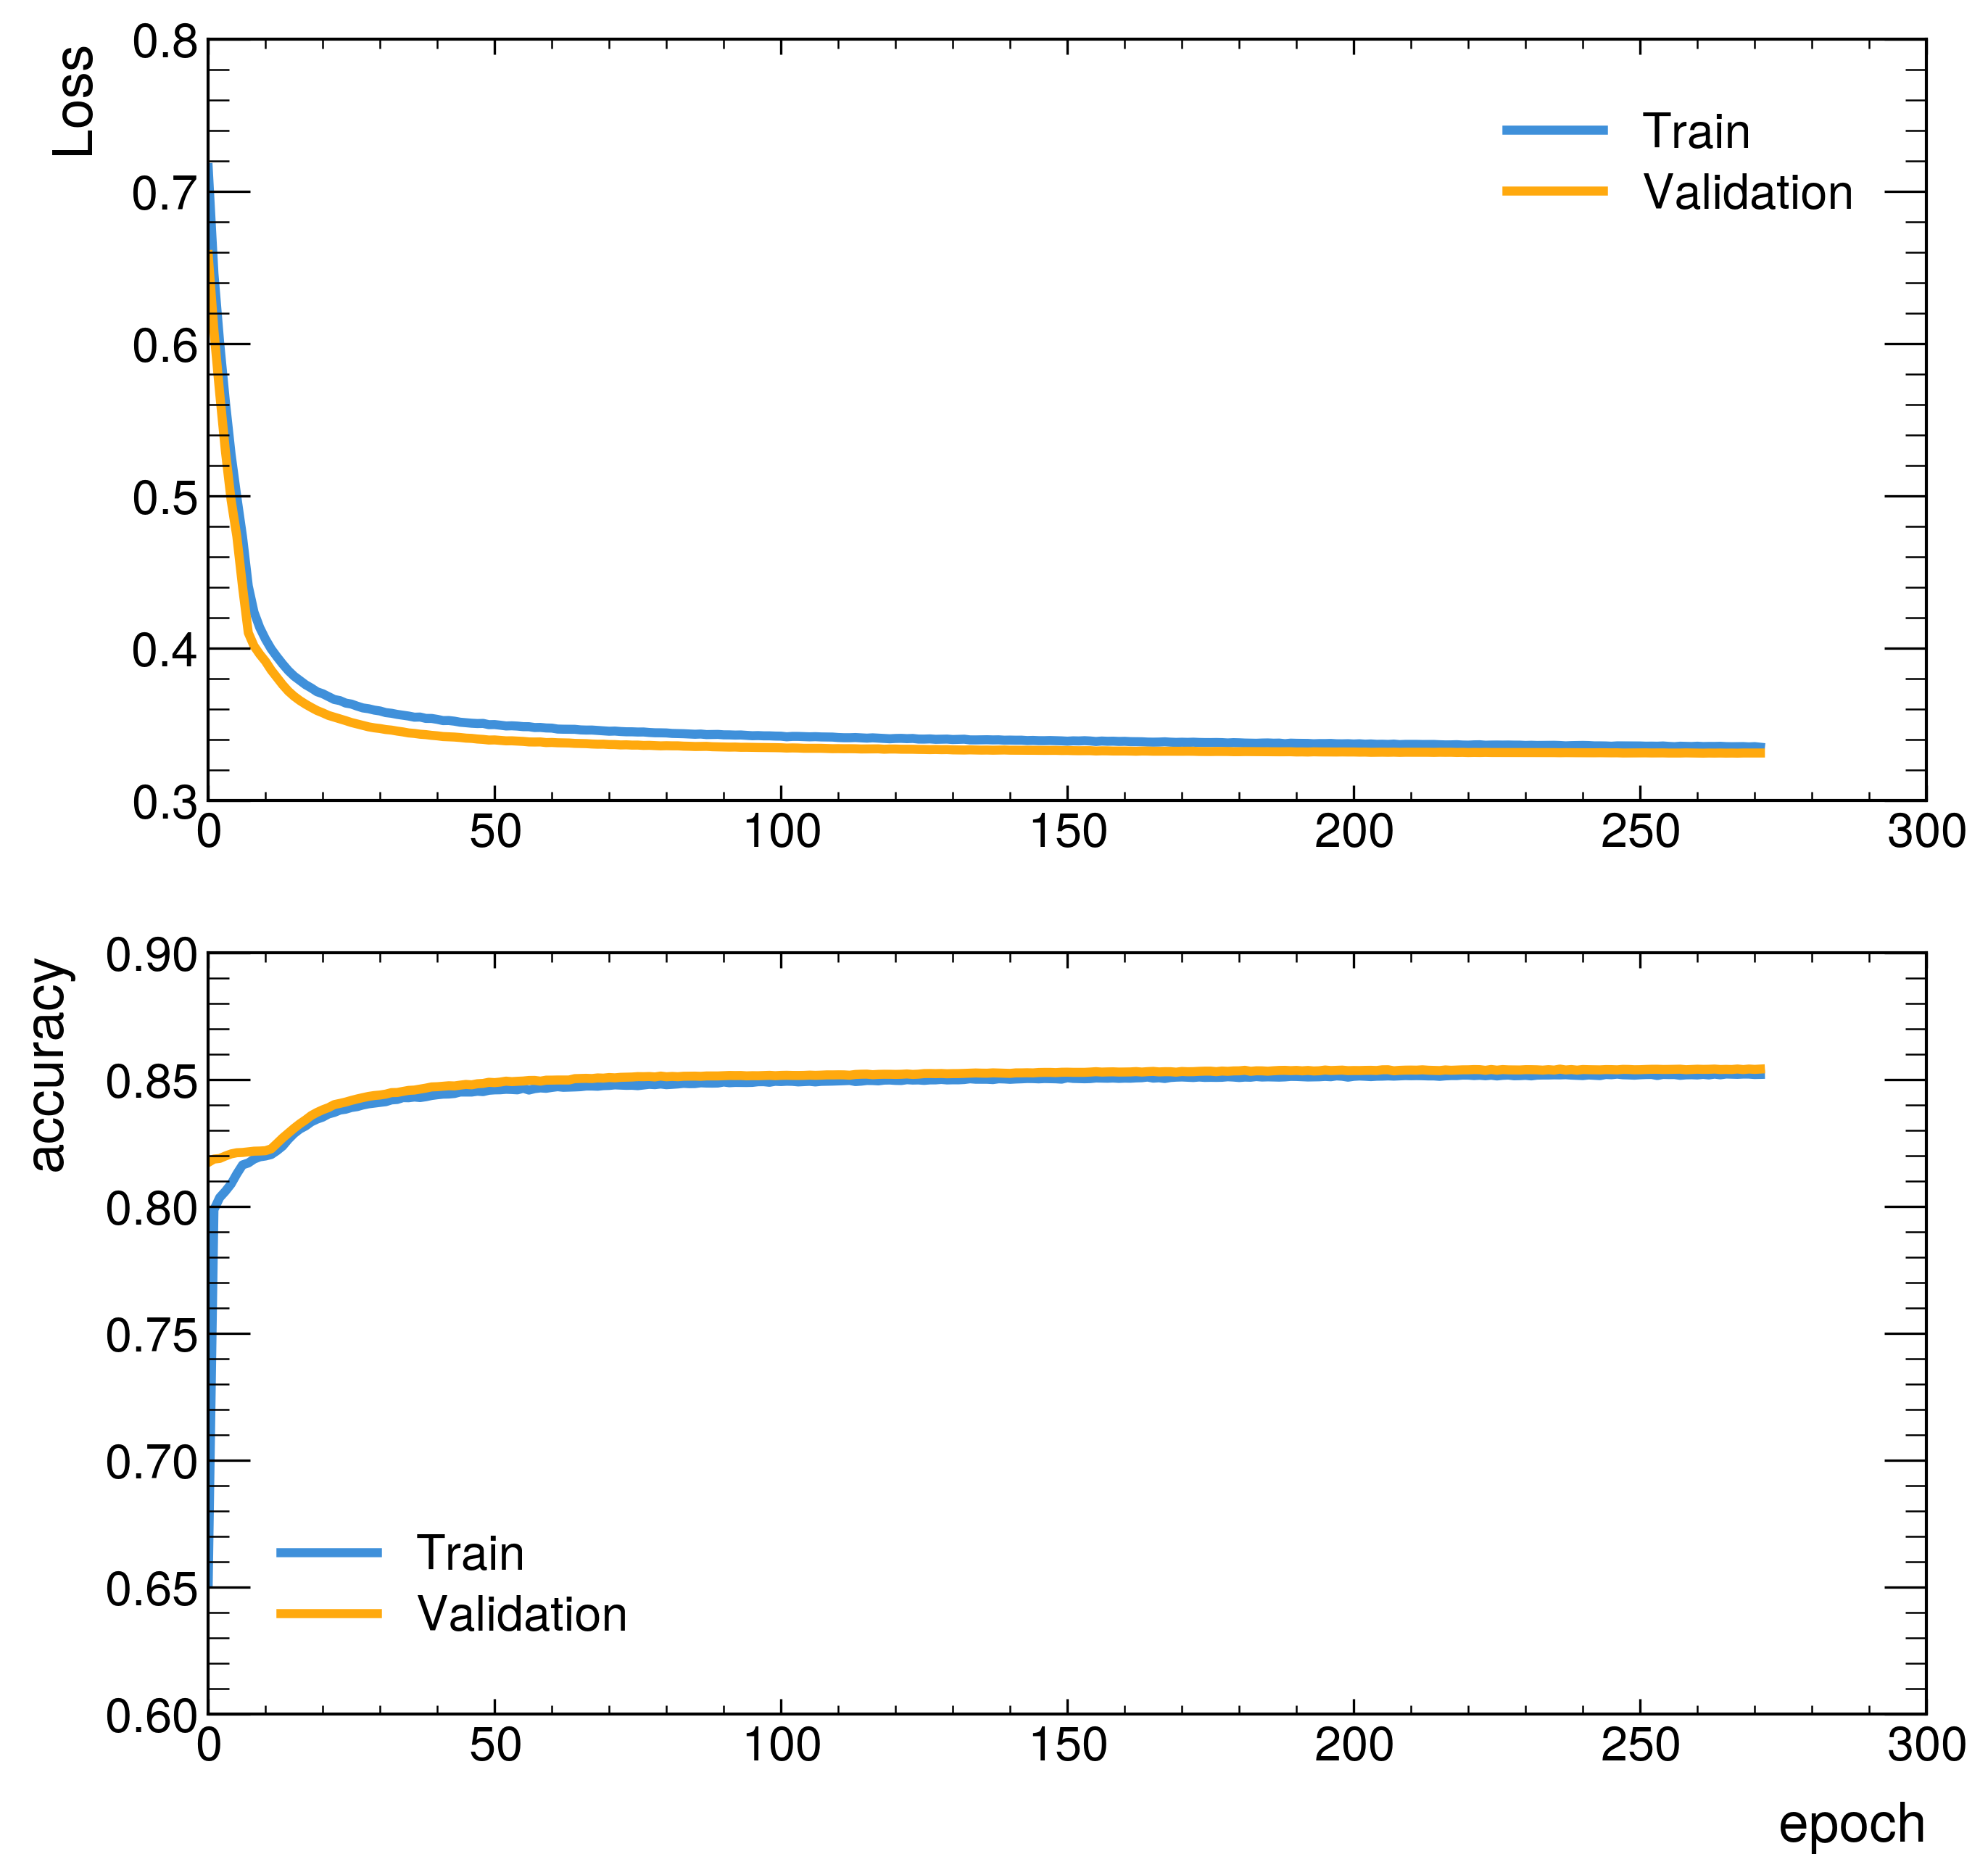

actual: 69831
predicted: 79011


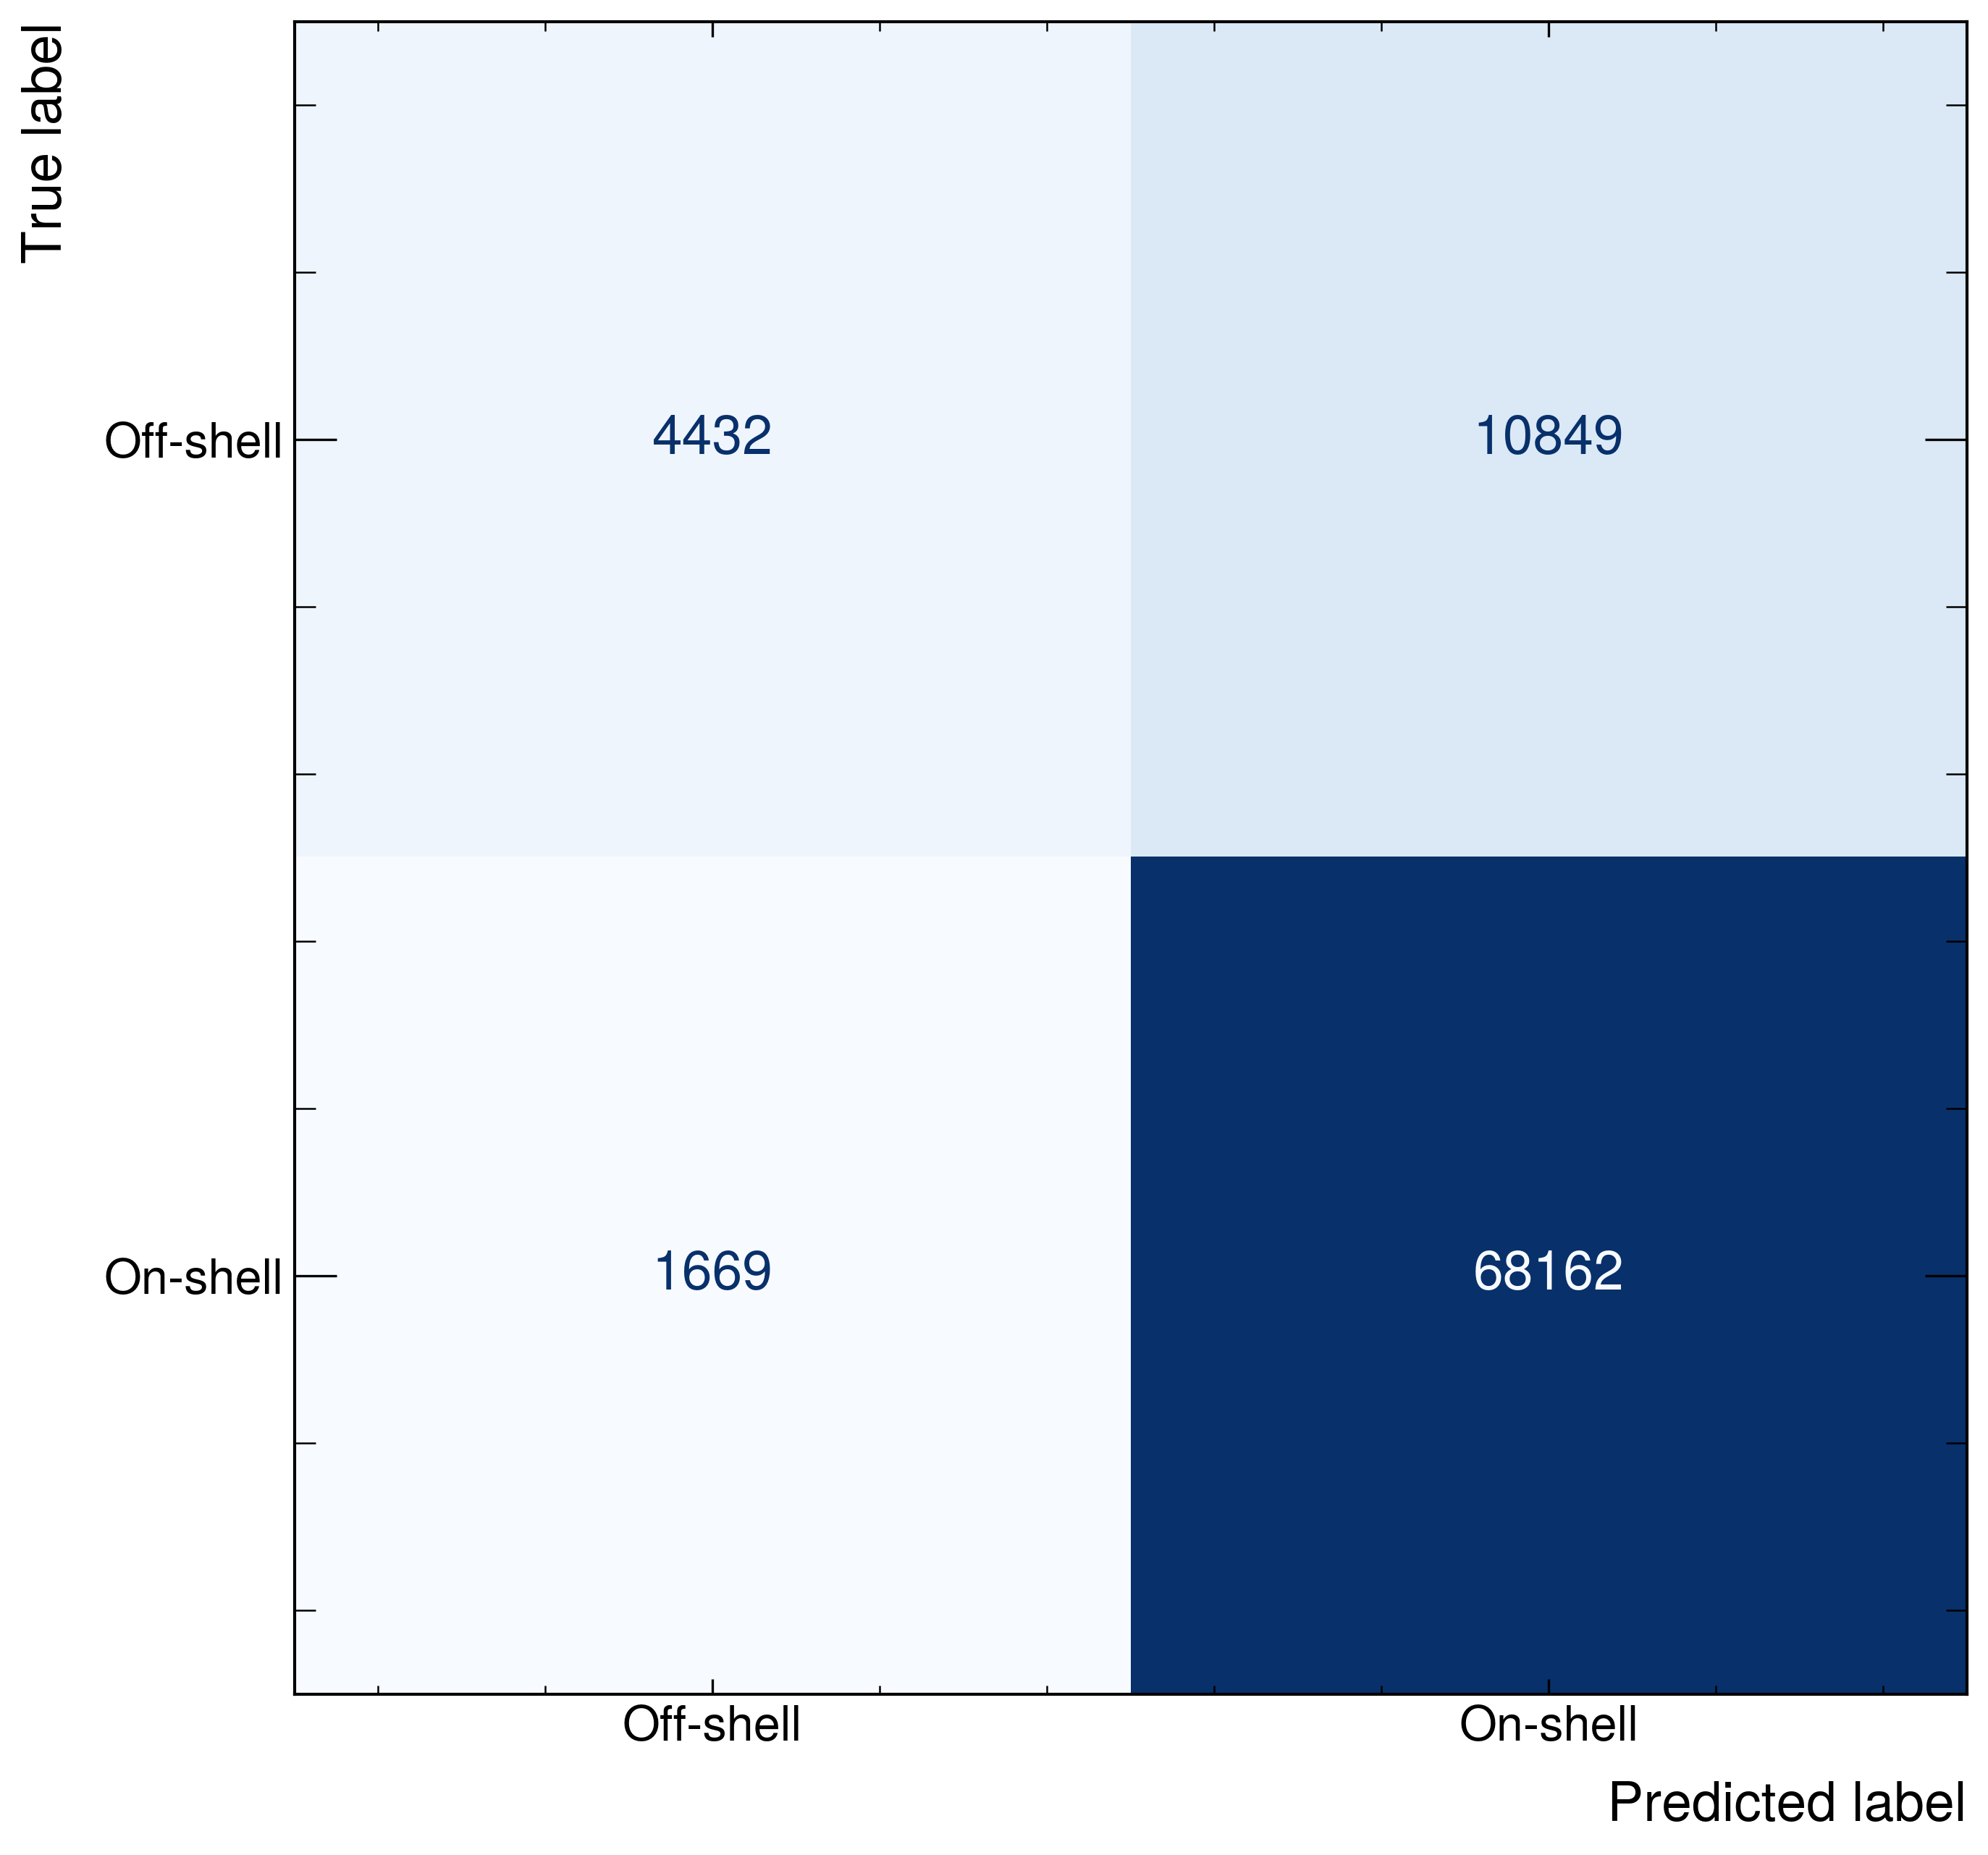

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

print("Accuracy:", np.mean(np.round(sig_pred) == sig_truth))

# Set global font sizes
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
})

fig = plt.figure(figsize=(10,10), dpi=300)
plt.subplot(2,1,1)
plt.plot(history.history['loss'], lw=3, label='Train')
plt.plot(history.history['val_loss'], lw=3, label='Validation')
plt.xlabel('')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], lw=3, label='Train')
plt.plot(history.history['val_accuracy'], lw=3, label='Validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

predicted = tf.squeeze(sig_pred) # ensure the dimension is correct (dim-1)
predicted = np.where(predicted >= 0.5, 1, 0)
labeled = np.where(sig_truth >= 0.5, 1, 0)
actual = np.array(sig_truth)
print("actual:", actual.sum())
print("predicted:", predicted.sum())

conf_mat = confusion_matrix(actual, predicted)
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Off-shell", "On-shell"])
displ.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()

/root/miniconda3/envs/tf/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/root/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(2048, 20))']
  warnings.warn(msg)
/root/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(4096, 20))']
  warnings.warn(msg)


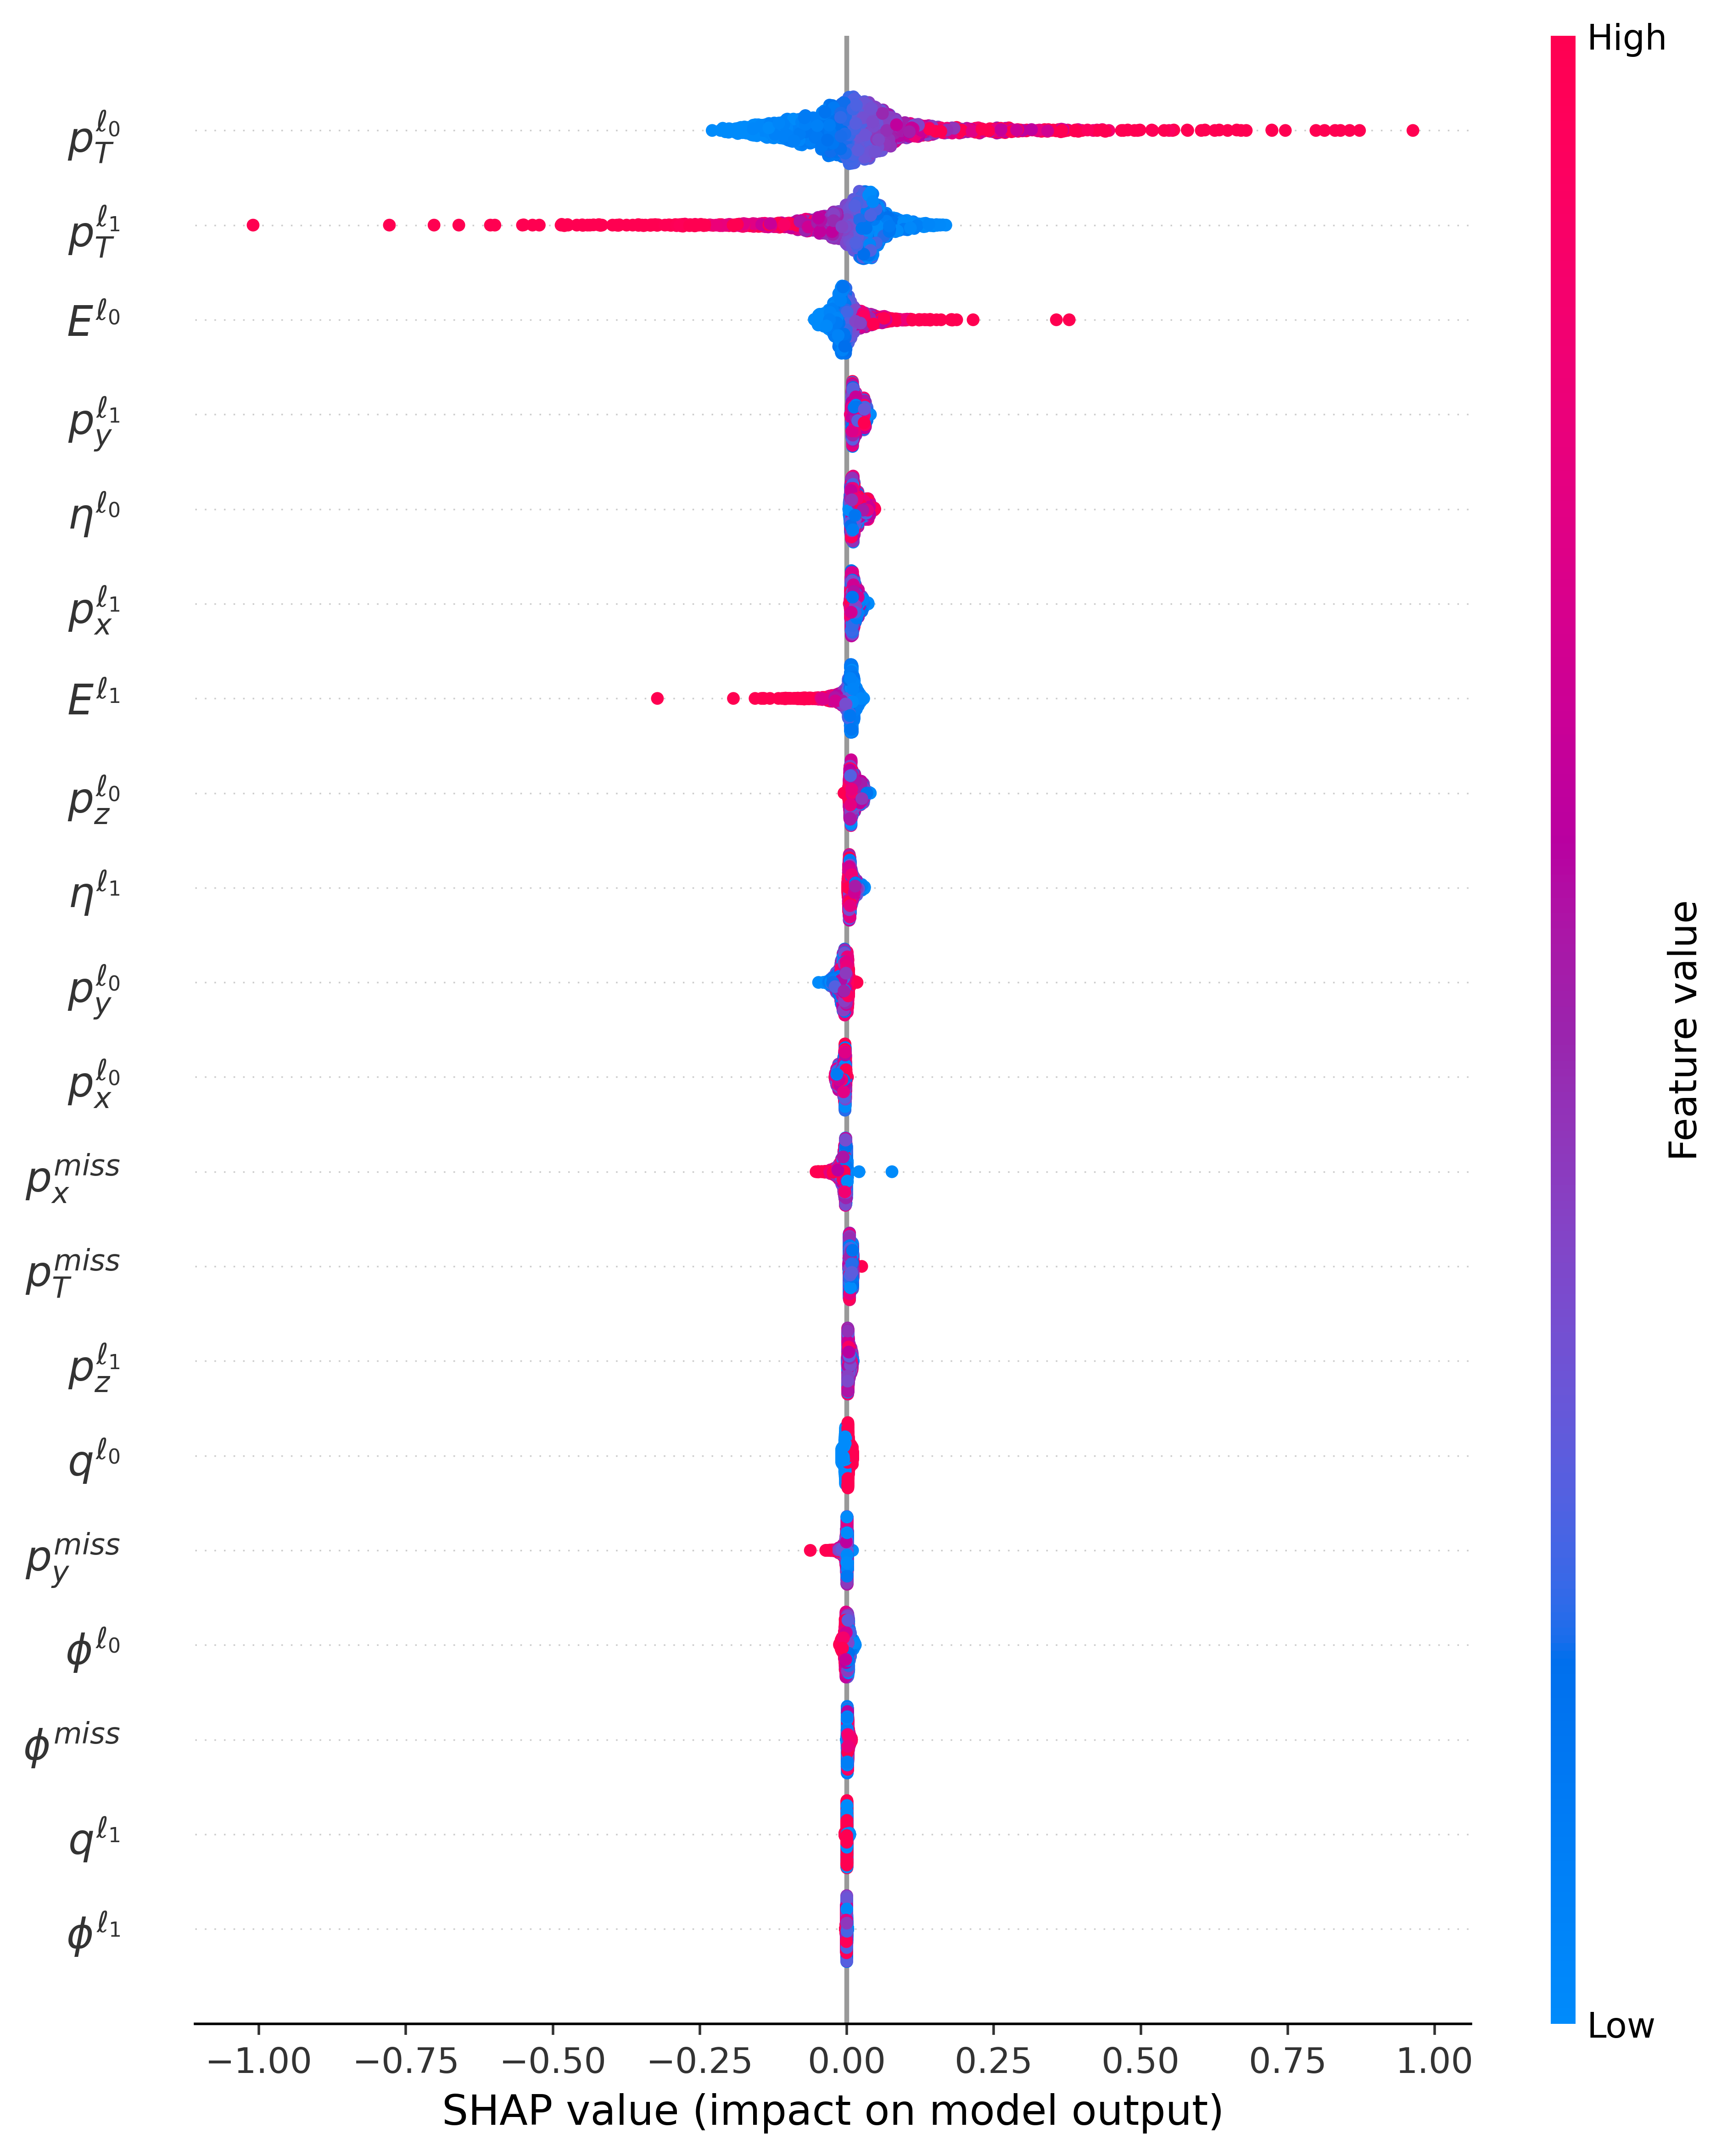

'-amx-complex' is not a recognized feature for this target (ignoring feature)
'-amx-fp16' is not a recognized feature for this target (ignoring feature)
'-avx10.1-256' is not a recognized feature for this target (ignoring feature)
'-avx10.1-512' is not a recognized feature for this target (ignoring feature)
'-avxifma' is not a recognized feature for this target (ignoring feature)
'-avxneconvert' is not a recognized feature for this target (ignoring feature)
'-avxvnniint16' is not a recognized feature for this target (ignoring feature)
'-avxvnniint8' is not a recognized feature for this target (ignoring feature)
'-cmpccxadd' is not a recognized feature for this target (ignoring feature)
'-prefetchi' is not a recognized feature for this target (ignoring feature)
'-raoint' is not a recognized feature for this target (ignoring feature)
'-rdpru' is not a recognized feature for this target (ignoring feature)
'-sha512' is not a recognized feature for this target (ignoring feature)
'-sm3' is n

In [18]:
import shap
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)

feature_names = [
    r"$p^{\ell_0}_{x}$",
    r"$p^{\ell_0}_{y}$",
    r"$p^{\ell_0}_{z}$",
    r"$E^{\ell_0}$",
    r"$p^{\ell_0}_{T}$",
    r"$\eta^{\ell_0}$",
    r"$\phi^{\ell_0}$",
    r"$q^{\ell_0}$",
    r"$p^{\ell_1}_{x}$",
    r"$p^{\ell_1}_{y}$",
    r"$p^{\ell_1}_{z}$",
    r"$E^{\ell_1}$",
    r"$p^{\ell_1}_{T}$",
    r"$\eta^{\ell_1}$",
    r"$\phi^{\ell_1}$",
    r"$q^{\ell_1}$",
    r"$p^{miss}_{x}$",
    r"$p^{miss}_{y}$",
    r"$p^{miss}_{T}$",
    r"$\phi^{miss}$"
]

# Use DeepExplainer for SHAP values
explainer = shap.DeepExplainer(model, obs_kin[1_024:3_072])
shap_values = explainer.shap_values(obs_kin[1_024:3_072], check_additivity=False)

fig = plt.figure(figsize=(7, 6), dpi=500)
for i in range(shap_values.shape[-1]):
    shap.summary_plot(
        shap_values[:, :, i],
        obs_kin[1_024:3_072],
        feature_names=feature_names,
        plot_type="dot",
        show=False,
    )
# plt.title(f"SHAP summary for on-off shell classifications")
plt.show()